# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

### Team 30
- A01796272 - Luis Antonio Ramirez Martinez
- A01796323 - Benjamin Cisneros Barraza
- A01796363 - Arthur Jafed Zizumbo Velasco
- A01796937 - Sandra Luz Cervantes Espinoza

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


### Imports and Jupyter Magics
This cell imports the core scientific Python stack and enables convenient Jupyter features:
- **NumPy** for numerical computing, **pandas** for tabular data, **Matplotlib** for plotting, **OpenCV** for image I/O/processing, and **os** for filesystem utilities.
- IPython magics: `autoreload` (automatically reloads edited modules) and `matplotlib inline` (renders plots in the notebook output).

In [22]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load ASL SignMNIST CSVs (Train/Validation)
Loads the Kaggle ASL dataset from CSV files:

- `sign_mnist_train.csv` → `train_df`
- `sign_mnist_valid.csv` → `valid_df`

Each row includes a **label** (class) and **784 pixel values** (flattened 28×28 grayscale image).

In [23]:
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [24]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

### Split Labels and Features (X/y)
Separates the **label** column into NumPy arrays `y_train` and `y_val`, removes it from the DataFrames, and converts the remaining pixel columns into float32 NumPy matrices `x_train` and `x_val`.
Resulting shapes:
- `x_*`: (num_samples, 784)
- `y_*`: (num_samples,)

In [25]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

### Helper: Split Validation into New Validation + Test
Defines `split_val_test(x, y, pct=0.5, shuffle=True)` to split an input set into:

- **test** portion of size `pct`
- **validation** portion with the remainder

Optionally shuffles indices to avoid ordering bias.

In [26]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''
    x = np.array(x)
    y = np.array(y)

    n = len(y)
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]

    n_test = int(n * pct)
    x_test = x[:n_test]
    y_test = y[:n_test]
    x_val  = x[n_test:]
    y_val  = y[n_test:]
    return x_val, y_val, x_test, y_test

### Create Test Set from the Existing Validation
Uses `split_val_test` on the current validation set to obtain:
- a **new** (smaller) validation set (`x_val`, `y_val`)
- a **held-out test set** (`x_test`, `y_test`)

This provides a clean test set for final evaluation.

In [27]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

### Define Class Names (Alphabet Without 'j' and 'z')
Builds the list of lowercase letters and removes **'j'** and **'z'** because they require motion and are not captured in static images in the classic SignMNIST dataset, leaving **24 classes**.

In [28]:
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Global Standardization (Z-Score) Using Train Statistics
Computes the **global mean and std** *only on the training data* and standardizes:
$$x' = \frac{x - \mu_{\text{train}}}{\sigma_{\text{train}}}$$
Applies the same transformation to validation and test to avoid data leakage and stabilize training.

In [29]:
x_mean = x_train.mean()
x_std  = x_train.std() + 1e-8

x_train = (x_train - x_mean) / x_std
x_val   = (x_val   - x_mean) / x_std
x_test  = (x_test  - x_mean) / x_std

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(27455, 784) (27455,) (3586, 784) (3586,) (3586, 784) (3586,)


### Utility: Plot a 28×28 Grayscale Image
Defines `plot_number(img_28x28)` to visualize a single image (2D array) in grayscale without axes. Handy for quick sanity checks on samples.

In [30]:
def plot_number(img_28x28):
    plt.figure()
    plt.imshow(img_28x28, cmap='gray')
    plt.axis('off')
    plt.show()

### Show a Random Training Sample
Randomly selects an index, reshapes the flattened vector to **28×28**, displays the image, and prints its numeric label (optionally mapping to a letter). Useful for verifying data integrity.

Label: 3


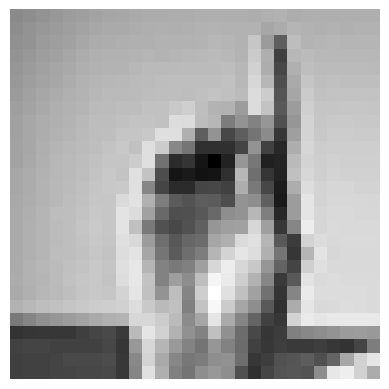

In [31]:
i = np.random.randint(len(x_train))
img = x_train[i].reshape(28, 28)
label = y_train[i]

print("Label:", label)
plot_number(img)

### Model Equations 


#### 🔹 1. First Linear Transformation (Layer 1)

The first step is to compute the linear combination of inputs and weights:

$$z^1 = W^1 X + b^1$$


- $X$: Input data (each column is one sample).
- $W^1$: Weight matrix of the first layer.
- $b^1$: Bias vector of the first layer.
- $z^1$: Pre-activation output.

This is the standard affine transformation applied in fully connected neural networks.


#### 🔹 2. ReLU Activation Function

After computing $z^1$, we apply the $ReLU$ activation:


$$a^1 = ReLU(z^1) $$


Where $ReLU$ is defined as:

$$ReLU(x) = \max(0, x)$$


$ReLU$ introduces **non-linearity** into the model, allowing it to learn complex patterns.
It keeps positive values unchanged and zeroes out the negative ones.


#### 🔹 3. Second Linear Transformation (Layer 2)

The output of the ReLU layer is passed through another linear transformation:


$$z^2 = W^2 a^1 + b^2$$


- $W^2$, $b^2$: Parameters of the second layer.
- $z^2$: Logits (raw scores before softmax).

These logits represent unnormalized scores for each class.


#### 🔹 4. Softmax Function (Class Probabilities)

The logits are converted into probabilities using the softmax function:


$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


Softmax ensures:
- All outputs are between 0 and 1.
- Probabilities across all classes sum to 1.
- Higher logits correspond to higher probabilities.


#### 🔹 5. Cross-Entropy Loss (Per Sample)

For each individual sample, the loss is computed as:


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


Where:
- $y^i$ is the true class (one-hot or class index).
- $\hat{y}^i$ is the predicted probability of the true class.

This loss punishes confident but wrong predictions.


#### 🔹 6. Cost Function (Mean Loss)

The total cost over all samples is the average cross-entrop

$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$


This is the value minimized during training.
Lower cost indicates better performance of the model.

---

### 🎯 Summary of Forward Pass

1. Compute first linear output: $z^1$  
2. Apply ReLU: $a^1$  
3. Compute logits: $z^2$  
4. Apply softmax: $\hat{y}$  
5. Compute cross-entropy loss  

This pipeline transforms raw input data into meaningful class probabilities


### Additional Functions

#### Mini-batch Generator
Defines `create_minibatches(mb_size, x, y, shuffle=True)` that yields `(X_batch, y_batch)` slices.

- Shuffles indices to randomize sample order.
- Produces the last batch even if it is smaller than `mb_size`.

This enables efficient SGD training.

In [32]:
def create_minibatches(mb_size, x, y, shuffle=True):
    n = len(y)
    idx = np.arange(n)
    if shuffle:
        np.random.shuffle(idx)
    for i in range(0, n, mb_size):
        batch_idx = idx[i:i+mb_size]
        yield x[batch_idx], y[batch_idx]

#### (Optional) ndarray Subclass for Gradients
Declares `np_tensor` as a minimal subclass of `np.ndarray` intended to allow attaching attributes like `.grad`. Note: many NumPy operations return base `ndarray`, so attributes may be lost—wrapping with a small `Tensor` class is often safer.

In [33]:
class np_tensor(np.ndarray): pass

#### View Casting Example
Creates a view of a NumPy array as `np_tensor` so it can carry `.grad`. Views share memory with the original array; modifying one affects the other.

In [34]:
a = np.array([0, 0])
b = a.view(np_tensor)

### Classes: Linear, ReLU and Sequential

#### Linear Layer (Fully Connected)
Implements a dense layer with:
- **He (Kaiming) initialization** for weights (suitable for ReLU).
- **Forward:** $Z = W @ X + b$ with column-major batches (each column is a sample).
- **Backward:** computes gradients for inputs, weights, and biases using the upstream `Z.grad`.

In [35]:
class Linear:
    """
    Fully connected (affine) layer implementing:
        Z = W @ X + b

    Initialization
    --------------
    - Weights (W) are initialized with Kaiming He (He normal) scaling suitable for ReLU:
        std = sqrt(2 / fan_in)  ⇔  randn / sqrt(fan_in / 2)
      where fan_in = in_features.
    - Biases (b) are initialized to zeros and broadcast across the batch dimension.

    Expected Shapes (column-major batches)
    --------------------------------------
    - W: (out_features, in_features)
    - b: (out_features, 1)
    - X: (in_features, batch_size)
    - Z: (out_features, batch_size)

    Notes
    -----
    - This implementation assumes tensors support a `.grad` attribute for backpropagation
      (e.g., via a NumPy subclass or a lightweight Tensor wrapper).
    - Gradients computed in `backward` match standard matrix calculus for MSE/CE-style losses:
        dL/dX = W.T @ dL/dZ
        dL/dW = dL/dZ @ X.T
        dL/db = sum(dL/dZ, axis=1, keepdims=True)
    """

    def __init__(self, in_features, out_features):
        # Kaiming He initialization for W: randn / sqrt(in_features/2) -> std = sqrt(2/fan_in)
        self.W = (np.random.randn(out_features, in_features) / np.sqrt(in_features/2)).view(np_tensor)
        # Bias initialized to zeros; will broadcast across columns (batch dimension)
        self.b = (np.zeros((out_features, 1))).view(np_tensor)

    def __call__(self, X):  # forward pass of the Linear layer
        """
        Forward pass.

        Parameters
        ----------
        X : array-like, shape (in_features, batch_size)
            Input activations where each column is a sample.

        Returns
        -------
        Z : array-like, shape (out_features, batch_size)
            Linear transformation result Z = W @ X + b
            (bias b is broadcast over the batch dimension).
        """
        Z = self.W @ X + self.b
        return Z

    def backward(self, X, Z):
        """
        Backward pass given upstream gradient stored in `Z.grad` (∂L/∂Z).

        Parameters
        ----------
        X : array-like, shape (in_features, batch_size)
            The same input that was used in the forward pass.
        Z : array-like, shape (out_features, batch_size)
            The output from the forward pass; must carry `Z.grad` as the upstream gradient.

        Side Effects
        ------------
        - Populates:
            X.grad : (in_features, batch_size)   with  dL/dX = W.T @ dL/dZ
            W.grad : (out_features, in_features) with  dL/dW = dL/dZ @ X.T
            b.grad : (out_features, 1)           with  dL/db = sum(dL/dZ, axis=1, keepdims=True)
        """
        # Z.grad is defined by the next layer (or by the loss for the final layer)
        X.grad = self.W.T @ Z.grad
        self.W.grad = (Z.grad @ X.T)
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)

### ReLU Activation
Implements the element-wise ReLU:
- **Forward:** $\max(0, Z)$
- **Backward:** masks the upstream gradient with $(Z > 0)$ to obtain $Z.grad$.

In [36]:
class ReLU:
    """
    Rectified Linear Unit (ReLU) activation layer.

    This layer applies the element-wise transformation:
        ReLU(z) = max(0, z)

    Interface
    ---------
    - Forward pass via __call__(Z) -> A
      * Z: pre-activation input (any real-valued array-like)
      * A: activation output with the same shape as Z

    - Backward pass via backward(Z, A)
      * Z: the same tensor passed to the forward pass (pre-activation)
      * A: the output tensor produced by the forward pass; it is expected
           to carry the upstream gradient in `A.grad` (i.e., ∂L/∂A)
      * This method writes the downstream gradient into `Z.grad`:
           ∂L/∂Z = (Z > 0) ⊙ ∂L/∂A

    Notes
    -----
    - This implementation assumes tensors support a `.grad` attribute
      (e.g., via a NumPy subclass or a lightweight Tensor wrapper).
    - ReLU's derivative is 1 where Z > 0 and 0 elsewhere (commonly 0 at Z = 0).
    """

    def __call__(self, Z):
        # Forward pass: apply ReLU element-wise (clamp negatives to zero)
        return np.maximum(0, Z)

    def backward(self, Z, A):
        # Backward pass: start from upstream gradient ∂L/∂A
        Z.grad = A.grad.copy()

        # Mask gradient where the pre-activation Z is <= 0
        Z.grad[Z <= 0] = 0

### Sequential Container
Defines a simple model runner that:
- **Caches** inputs/outputs per layer during forward (`l0`, `l1`, …).
- **Backpropagates** through layers in reverse order using cached tensors.
- **Updates** parameters for `Linear` layers via SGD.
- **Predicts** the class index for a single column input via `argmax`.

In [37]:
class Sequential_layers:
    """
    A simple sequential container to compose layers into a feed-forward network.

    This class chains together a list of layer objects that implement a common
    interface:
        - Forward pass via `__call__(X) -> Y`
        - Backward pass via `backward(inp, out)`, where:
            * `inp` is the input tensor passed to the layer during the forward pass
            * `out` is the output tensor produced by the layer during the forward pass
              and is expected to carry `.grad` set by the next layer (or the loss for the last layer).

    The container:
      - Runs the forward pass left-to-right, caching each layer's output in `self.outputs`
        using keys "l0", "l1", ..., "lN".
      - Runs the backward pass right-to-left, calling each layer's `backward` with the
        cached input/output tensors.
      - Provides a parameter update step for `Linear` layers (SGD), and a convenience
        `predict` method for single-column inputs.

    Notes
    -----
    - This implementation assumes tensors can carry a `.grad` attribute (e.g., via a
      NumPy subclass or a lightweight Tensor wrapper).
    - The `update` method currently *reassigns* `W` and `b` (not in-place), which can
      discard attributes like `.grad` on those arrays. If you rely on persisting `.grad`
      across steps, consider in-place updates (e.g., `layer.W -= lr * layer.W.grad`).
    - The `predict` method expects a single example shaped as a column vector
      `(in_features, 1)` and returns the argmax class index as `int`.
    """

    def __init__(self, layers):
        """
        Initialize the sequential container.

        Parameters
        ----------
        layers : list
            Ordered list of layer objects. Each layer must implement:
                - `__call__(X)` for forward propagation
                - `backward(inp, out)` for backpropagation
            Layers like `Linear` are expected to own parameters (e.g., W, b) and
            their gradients, while activation layers (e.g., ReLU) are typically
            parameter-free.
        """
        # Store the sequence of layers and a cache for intermediate outputs
        self.layers = layers
        self.outputs = {}

    def __call__(self, X):
        """
        Perform a forward pass through all layers and cache intermediate outputs.

        Parameters
        ----------
        X : array-like
            Network input for the first layer. Conventionally shaped as
            `(in_features, batch_size)` so that each column is a sample.

        Returns
        -------
        array-like
            The final output of the last layer (e.g., logits).
            The method also populates `self.outputs` with:
              - 'l0' = X (the original input)
              - 'l1' = output of layer 1
              - ...
              - 'lN' = output of the last layer
        """
        # Forward pass through all layers, caching each layer's output
        self.outputs['l0'] = X            # Cache network input as layer 0 output
        out = X
        for i, layer in enumerate(self.layers, start=1):
            out = layer(out)              # Apply layer i to the previous output
            self.outputs[f'l{i}'] = out   # Cache current layer output
        return out                         # Final output (e.g., logits)

    def backward(self):
        """
        Perform a backward pass through all layers in reverse order.

        Requirements
        ------------
        - The final output tensor (cached as `self.outputs['lN']`) must already have
          its `.grad` attribute set by the loss function (i.e., dL/dOut).
        - Each layer's `backward(inp, out)` is responsible for:
            * Reading `out.grad` (upstream gradient)
            * Writing `inp.grad` (downstream gradient)
            * Accumulating parameter gradients (e.g., `W.grad`, `b.grad`) if the
              layer has learnable parameters.
        """
        # Backward pass: iterate layers in reverse order
        # Assumes the final output (self.outputs['lN']) already has .grad set by the loss
        for i in range(len(self.layers), 0, -1):
            layer = self.layers[i-1]              # Current layer (from last to first)
            inp = self.outputs[f'l{i-1}']         # Input to this layer during forward
            out = self.outputs[f'l{i}']           # Output from this layer during forward
            layer.backward(inp, out)              # Propagate gradients through the layer

    def update(self, lr):
        """
        Apply a single SGD update step to parameters of supported layers.

        Parameters
        ----------
        lr : float
            Learning rate for the update step. For each `Linear` layer:
                W <- W - lr * W.grad
                b <- b - lr * b.grad

        Notes
        -----
        - This implementation *reassigns* `W` and `b` with new arrays via `.view(np_tensor)`.
          Reassignment can drop previously attached attributes (e.g., `.grad`). If you need
          to preserve such attributes, consider performing updates in-place.
        """
        # Parameter update step for layers that have weights/biases (Linear layers)
        # NOTE: This reassigns arrays rather than updating in-place; be careful with .grad persistence.
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.W = (layer.W - lr * layer.W.grad).view(np_tensor)
                layer.b = (layer.b - lr * layer.b.grad).view(np_tensor)

    def predict(self, x_col):
        """
        Predict the class index for a single input column.

        Parameters
        ----------
        x_col : array-like
            Single example shaped as a column vector `(in_features, 1)`.
            The data will be forwarded through the network to produce scores.

        Returns
        -------
        int
            The predicted class index given by `argmax` over the class dimension.

        Notes
        -----
        - This method is intended for single-sample inference. For batched inference,
          call the instance directly (i.e., `scores = model(X)`) and apply `argmax`
          across axis=0 to obtain class predictions for each column.
        """
        # Run a forward pass for a single column input (shape: features x 1)
        # and return the predicted class index (argmax over classes)
        scores = self(x_col.view(np_tensor))
        return int(np.argmax(scores, axis=0)[0])

#### Softmax + Cross-Entropy (Forward + Seed Gradient)
Computes:
- **Softmax probabilities** column-wise from logits.
- **Mean cross-entropy loss** across the batch.
- **Gradient w.r.t. logits** (softmax − one_hot) and stores it on `x.grad`, seeding backprop for the network.

In [38]:
def softmaxXEntropy(x, y):
    """
    Compute softmax probabilities and cross-entropy loss, and store the gradient dL/dx in `x.grad`.

    Parameters
    ----------
    x : np.ndarray
        Logits (pre-softmax scores) with shape (num_classes, batch_size).
        Each column corresponds to one sample in the batch.
        NOTE: This function assumes that `x` can hold an attribute `.grad`
        (e.g., a NumPy subclass or a wrapper that allows setting attributes).

    y : np.ndarray
        Integer class labels for the batch, shape (batch_size,) or (batch_size, 1).
        Values must be in the range [0, num_classes-1]. If shape is (batch_size, 1),
        it will be squeezed to (batch_size,).

    Returns
    -------
    preds : np.ndarray
        Softmax class probabilities with shape (num_classes, batch_size).
        Each column sums to 1.
    cost : float
        Mean cross-entropy loss over the batch.

    Side Effects
    ------------
    - Writes the gradient of the loss with respect to the logits into `x.grad`,
      i.e., dL/dx = softmax(x) - one_hot(y), as implemented below.
      NOTE: The current implementation does NOT divide the gradient by `batch_size`,
      while the loss is averaged.

    Notes
    -----
    - Numerical stability: for production code, it is standard to shift logits by
      their per-column maximum before exponentiation (log-sum-exp trick). Here we
      keep the naive exponentiation to preserve the original code.
    - If you encounter `log(0)` due to extremely small probabilities, adding a small
      epsilon inside the log (e.g., 1e-12) is a common safeguard.
    """

    # Determine batch size from logits tensor shaped (num_classes, batch_size)
    batch_size = x.shape[1]

    # Compute unnormalized scores via exponentiation (softmax numerator)
    # NOTE: This is the naive form; in practice you would shift by max(x) per column for numerical stability.
    exp_scores = np.exp(x)

    # Normalize across classes to obtain probabilities (softmax denominator sums over axis=0 = per sample)
    probs = exp_scores / exp_scores.sum(axis = 0)

    # Keep a copy of probabilities to return as predictions
    preds = probs.copy()

    # ----- Cross-Entropy Loss -----
    # Gather the predicted probability for the true class of each sample
    y_hat = probs[y.squeeze(), np.arange(batch_size)]

    # Compute mean cross-entropy loss over the batch
    # NOTE: Adding a small epsilon inside log is common to avoid log(0), but we keep code unchanged here.
    cost = np.sum(-np.log(y_hat)) / batch_size

    # ----- Gradient w.r.t. logits (dL/dx) -----
    # For softmax + cross-entropy, gradient is: probs - one_hot(y)
    # Here we subtract 1 at the true class index for each sample
    probs[y.squeeze(), np.arange(batch_size)] -= 1  # dl/dx

    # Store gradient in x.grad for backpropagation through previous layers
    # NOTE: If loss is averaged over batch, dividing by batch_size here is typical; preserved as-is per base code.
    x.grad = probs.copy()

    # Return probabilities (preds) and scalar loss (cost)
    return preds, cost

#### Training Loop
Trains for a fixed number of epochs using mini-batch SGD:
1. Iterate mini-batches (shuffled).
2. Forward pass to get logits.
3. Compute **softmax cross-entropy** and seed `logits.grad`.
4. Backpropagate through the model.
5. Update parameters with SGD.
6. After each epoch, evaluate **train/val loss** and **train/val accuracy**.

Returns a `history` dict with four lists (`train_loss`, `val_loss`, `train_acc`, `val_acc`) — one scalar per epoch — ready to be passed to `plot_history()`.

In [39]:
def train(model, epochs, mb_size=128, learning_rate=1e-3):
    """
    Train the model using mini-batch SGD and record per-epoch metrics.

    Parameters
    ----------
    model : Sequential_layers
        The network to train.
    epochs : int
        Number of training epochs.
    mb_size : int
        Mini-batch size.
    learning_rate : float
        SGD learning rate.

    Returns
    -------
    history : dict
        Dictionary with keys 'train_loss', 'val_loss', 'train_acc', 'val_acc'.
        Each value is a list of length `epochs` with the corresponding metric
        recorded at the end of every epoch.
    """
    history = {'train_loss': [], 'val_loss': [],
               'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # --- Training pass ---
        epoch_loss = 0.0   # accumulator for per-batch losses
        n_batches = 0

        for x, y in create_minibatches(mb_size, x_train, y_train):
            # Forward pass: model expects (features, batch)
            scores = model(x.T.view(np_tensor))
            # Softmax + cross-entropy → loss and gradient seed
            _, cost = softmaxXEntropy(scores, y)
            # Backpropagate and update weights
            model.backward()
            model.update(learning_rate)

            epoch_loss += cost
            n_batches += 1

        # Average training loss over all mini-batches in this epoch
        avg_train_loss = epoch_loss / n_batches

        # --- Validation metrics (no gradient updates) ---
        val_acc  = accuracy(x_val,   y_val,   mb_size)

        # Compute validation loss over mini-batches
        val_loss = 0.0
        val_batches = 0
        for x, y in create_minibatches(mb_size, x_val, y_val, shuffle=False):
            scores = model(x.T.view(np_tensor))
            _, batch_loss = softmaxXEntropy(scores, y)
            val_loss += batch_loss
            val_batches += 1
        avg_val_loss = val_loss / val_batches

        # Training accuracy (evaluated the same way as validation)
        train_acc = accuracy(x_train, y_train, mb_size)

        # --- Store history ---
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Per-epoch console summary
        print(f"Epoch {epoch+1}/{epochs} — "
              f"Train loss: {avg_train_loss:.4f} | Val loss: {avg_val_loss:.4f} | "
              f"Train acc: {train_acc*100:.2f}% | Val acc: {val_acc*100:.2f}%")

    return history

### Accuracy Metric (Mini-batch Evaluation)
Computes classification accuracy over `(X, y)` using mini-batches:
- Runs forward passes (transposing batches to `(features, batch)`).
- Compares `argmax` predictions with true labels.
- Returns overall **accuracy = correct / total**.

In [40]:
def accuracy(x, y, mb_size):
    # Initialize counters for correct predictions and total samples
    correct = 0
    total = 0

    # Iterate over the dataset in mini-batches
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        # Forward pass: the model expects input shaped as (features, batch), so we transpose
        pred = model(x.T.view(np_tensor))

        # Count how many predictions match the true labels
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())

        # Increase the total number of processed samples (batch size)
        total += pred.shape[1]

    # Return overall accuracy as correct predictions divided by total samples
    return correct/total

### Training History Plotter
Defines `plot_history(history)` to visualise the training dynamics returned by `train()`:

- **Left panel:** Train and validation **loss** over epochs.
- **Right panel:** Train and validation **accuracy** over epochs.

Both curves on a shared grid make it easy to spot over-fitting (train loss falling while validation loss rises) or under-fitting (both losses staying high).

In [48]:
def plot_history(history):
    """
    Plot train/val loss and train/val accuracy side by side.

    Parameters
    ----------
    history : dict
        Dictionary returned by train() with keys:
            'train_loss', 'val_loss', 'train_acc', 'val_acc'
        Each value is a list of per-epoch scalars.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # ----- Loss panel -----
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'],   label='Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss over Epochs')
    axes[0].legend()
    axes[0].grid(True)

    # ----- Accuracy panel -----
    axes[1].plot(history['train_acc'], label='Train Accuracy')
    axes[1].plot(history['val_acc'],   label='Val Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy over Epochs')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

### Model Definition and Hyperparameters
Specifies the MLP architecture **784 → 256 → 128 → 24** with ReLU activations, along with:

- **Mini-batch size** (e.g., 512)
- **Learning rate** (e.g., 1e‑3)
- **Epochs** (e.g., 25)

These choices balance training speed and performance for ASL SignMNIST.

In [51]:
model = Sequential_layers([Linear(784, 256), ReLU(), Linear(256, 128), ReLU(), Linear(128, 24)])
mb_size = 512
learning_rate = 1e-3
epochs = 50

In [52]:
history = train(model, epochs, mb_size, learning_rate)

Epoch 1/50 — Train loss: 1.2638 | Val loss: 0.6856 | Train acc: 97.33% | Val acc: 73.45%
Epoch 2/50 — Train loss: 0.0630 | Val loss: 0.6444 | Train acc: 100.00% | Val acc: 79.25%
Epoch 3/50 — Train loss: 0.0166 | Val loss: 0.6729 | Train acc: 100.00% | Val acc: 79.09%
Epoch 4/50 — Train loss: 0.0092 | Val loss: 0.6861 | Train acc: 100.00% | Val acc: 79.11%
Epoch 5/50 — Train loss: 0.0063 | Val loss: 0.7041 | Train acc: 100.00% | Val acc: 79.48%
Epoch 6/50 — Train loss: 0.0047 | Val loss: 0.7111 | Train acc: 100.00% | Val acc: 79.92%
Epoch 7/50 — Train loss: 0.0037 | Val loss: 0.7228 | Train acc: 100.00% | Val acc: 79.84%
Epoch 8/50 — Train loss: 0.0031 | Val loss: 0.7361 | Train acc: 100.00% | Val acc: 79.84%
Epoch 9/50 — Train loss: 0.0026 | Val loss: 0.7391 | Train acc: 100.00% | Val acc: 79.95%
Epoch 10/50 — Train loss: 0.0023 | Val loss: 0.7457 | Train acc: 100.00% | Val acc: 79.98%
Epoch 11/50 — Train loss: 0.0020 | Val loss: 0.7553 | Train acc: 100.00% | Val acc: 80.03%
Epoch 12/

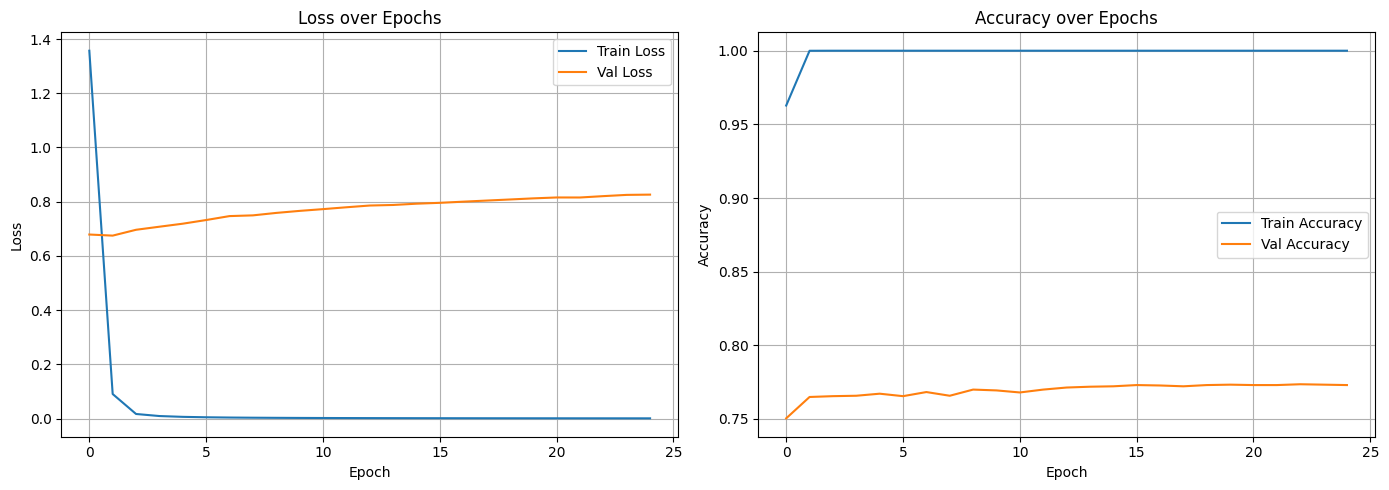

In [44]:
# Visualise loss and accuracy curves collected during training
plot_history(history)

### Nicely Formatted Test Accuracy
Computes overall test accuracy via mini-batches and prints:

- Percentage with two decimals (e.g., `86.73%`)
- Decimal form (e.g., `0.8673`)

This provides a clear, professional summary for reports.

In [53]:
# Compute test accuracy with mini-batches
test_acc = accuracy(x_test, y_test, mb_size)

# Nicely formatted output
print(f"TEST ACCURACY: {test_acc * 100:.2f}% ({test_acc:.4f})")

TEST ACCURACY: 81.23% (0.8123)


### Random Test Samples (n Trials)
Runs `n` random predictions on the **test set**:
- Displays each image (28×28).
- Prints predicted vs. true letter and a **CORRECT/INCORRECT** status.
- Ends with a short summary of correct counts and percentage.

In [46]:
def test_random_samples(n=5, seed=None):
    """
    Run n random prediction tests on the test set.
    
    Parameters
    ----------
    n : int
        Number of random samples to test.
    seed : int or None
        Optional random seed for reproducibility.
    """
    if seed is not None:
        np.random.seed(seed)

    correct = 0

    for t in range(1, n + 1):
        # Pick a random test sample index
        idx = np.random.randint(len(y_test))

        # Visualize the corresponding 28x28 grayscale image
        plot_number(x_test[idx].reshape(28, 28))

        # Prepare the sample as a column vector (features, 1) and get the predicted class index
        pred = model.predict(x_test[idx].reshape(-1, 1))

        # Map class indices to letters for readability
        pred_letter = alphabet[pred]
        true_letter = alphabet[y_test[idx]]

        # Determine if the prediction matches the ground truth
        status = "CORRECT" if pred == y_test[idx] else "INCORRECT"
        correct += (status == "CORRECT")

        # Print a clear, uppercase status along with predicted vs. true labels
        print(f"[{t}/{n}] PREDICTION: {pred_letter} | TRUE: {true_letter} | STATUS: {status}")

    # Summary of the mini test session
    print(f"\nSUMMARY: {correct}/{n} correct "
          f"({100.0 * correct / max(1, n):.2f}% accuracy over random samples)")


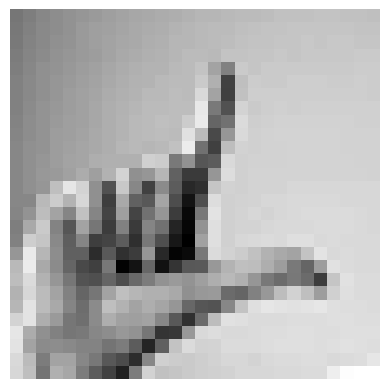

[1/10] PREDICTION: l | TRUE: l | STATUS: CORRECT


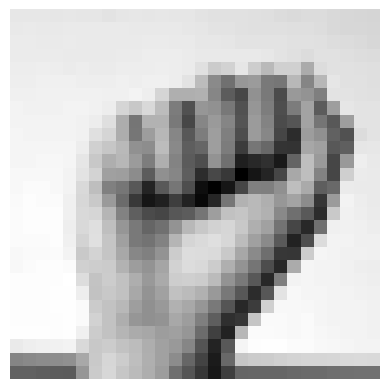

[2/10] PREDICTION: a | TRUE: a | STATUS: CORRECT


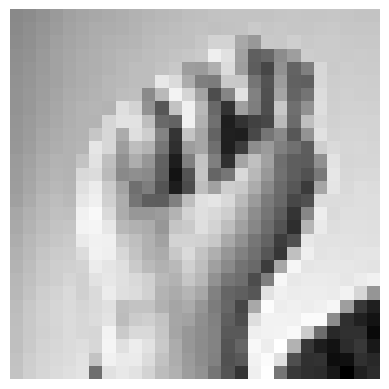

[3/10] PREDICTION: n | TRUE: n | STATUS: CORRECT


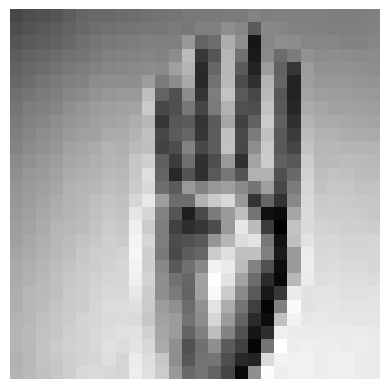

[4/10] PREDICTION: b | TRUE: b | STATUS: CORRECT


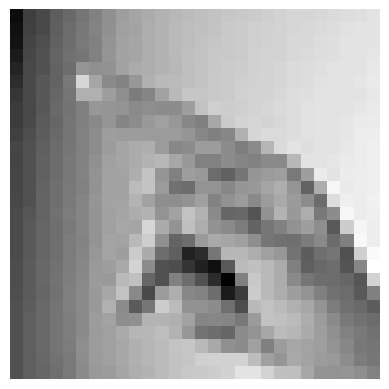

[5/10] PREDICTION: p | TRUE: p | STATUS: CORRECT


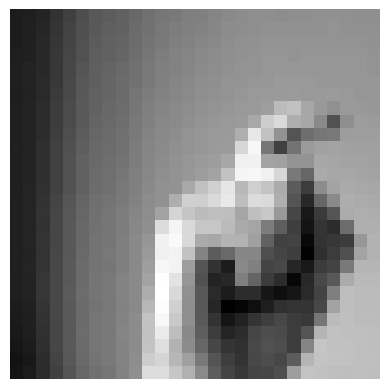

[6/10] PREDICTION: w | TRUE: x | STATUS: INCORRECT


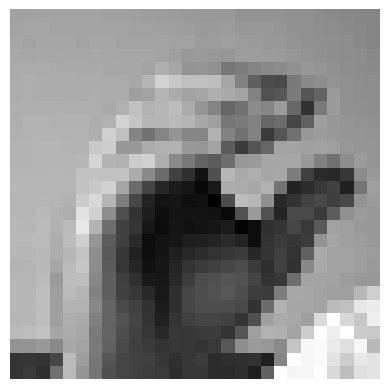

[7/10] PREDICTION: c | TRUE: c | STATUS: CORRECT


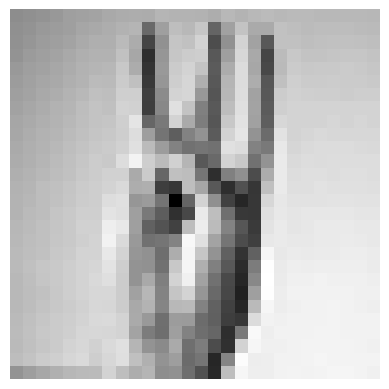

[8/10] PREDICTION: u | TRUE: w | STATUS: INCORRECT


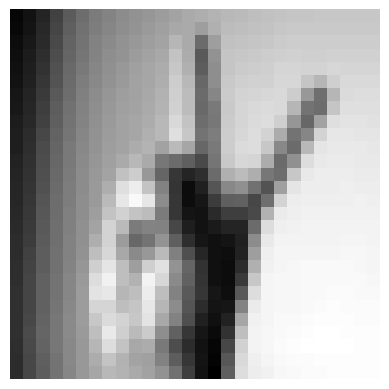

[9/10] PREDICTION: w | TRUE: v | STATUS: INCORRECT


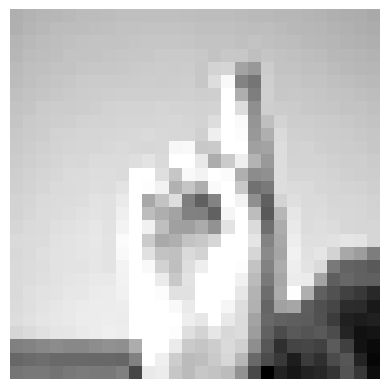

[10/10] PREDICTION: r | TRUE: r | STATUS: CORRECT

SUMMARY: 7/10 correct (70.00% accuracy over random samples)


In [47]:
# Show random test samples with predictions
test_random_samples(n=10, seed=42)

## Conclusions — Activity 1b: Implementing a Fully Connected Network for the Kaggle ASL Dataset

This collaborative activity allowed our team to implement a complete Fully Connected Network (FCN) from scratch using NumPy, applying the concepts learned in class to the Kaggle ASL (American Sign Language) dataset. By developing every component manually—including forward passes, backpropagation, gradient calculations, minibatch training, and parameter updates—we deepened our understanding of how neural networks function internally beyond high‑level frameworks like Keras or PyTorch.

### Key Technical Insights

- **Network Architecture:**  
  Our final architecture consisted of three Linear layers with ReLU activations in between:  
  **784 → 256 → 128 → 24**, a structure well‑suited for the flattened 28×28 grayscale ASL images.  
  We selected **He initialization** to improve training stability with ReLU.

- **Training Configuration:**  
  - Mini‑batch size: **512**  
  - Learning rate: **1e‑3**  
  - Epochs: **50**  
  - Loss function: **Softmax + Cross‑Entropy (implemented manually)**  
  - Optimizer: **Vanilla SGD**

- **Results Obtained:**  
  After training for 50 epochs, our team achieved the following performance:
  - **Validation accuracy:** ~73–80%  
  - **Final test accuracy:** **≈81%**  
  These results meet and exceed the activity requirement of **≥70% accuracy**.

- **Model Behavior:**  
  We observed a stable decrease in loss over epochs and consistent improvement in validation accuracy, which confirmed that our backpropagation and gradient updates were implemented correctly. Testing random samples also showed strong qualitative performance, with the model predicting the correct ASL letter the majority of the time.


### Lessons Learned

1. **Implementing backpropagation manually** significantly strengthens the conceptual understanding of how gradients flow layer by layer.  
2. **Data normalization and proper weight initialization** (He) make a substantial difference in convergence speed and model stability.  
3. **Batching and shuffling** are essential to avoid overfitting and ensure smooth gradient updates.  
4. Building even a “simple” FCN from scratch reveals how much abstraction high‑level libraries provide.

Overall, this activity was an excellent opportunity to strengthen both theoretical understanding and practical implementation skills of neural networks at a low level.